# WATCH and VEST Data Analysis

In [1]:
import os
import glob
import pandas as pd

# Get the root directory of the notebook
root_dir = os.getcwd()

# Create an empty DataFrame to store concatenated CSV data
combined_data = pd.DataFrame()

# Loop through the root directory
for filename in glob.iglob(root_dir + '/*.csv'):
    # Read each CSV file into a DataFrame
    df = pd.read_csv(filename)
    # Append the DataFrame to combined_data vertically
    combined_data = pd.concat([combined_data, df], axis=0)

# Display the combined DataFrame
print("Combined CSV data:")
print(combined_data)


Combined CSV data:
       axis 1  axis 2  axis 3  steps  lux  inclinometer off  \
0           0       0       0      0    0                 0   
1           0       0       0      0    0                 0   
2           0       0       0      0    0                 0   
3           0       0       0      0    0                 0   
4           0       0       0      0    0                 0   
...       ...     ...     ...    ...  ...               ...   
49198      39      50      64      0    0                 0   
49199      41      56      65      0    0                 0   
49200      24       0      53      1    0                 0   
49201       6       0      46      1    0                 0   
49202       0       0       8      0    0                 0   

       inclinometer standing  inclinometer sitting  inclinometer lying  \
0                          0                     1                   0   
1                          0                     1                   0   
2 

In [6]:
# Count the number of NaN values in the DataFrame
nan_count = combined_data.isna().sum().sum()
print("Number of NaN values in the DataFrame:", nan_count)


Number of NaN values in the DataFrame: 18459


In [7]:
# Remove NaN values from the DataFrame
combined_data.dropna(inplace=True)

# Print the DataFrame after removing NaN values
print("DataFrame after removing NaN values:")
print(combined_data)


DataFrame after removing NaN values:
       axis 1  axis 2  axis 3  steps  lux  inclinometer off  \
0           0       0       0      0    0                 0   
1           0       0       0      0    0                 0   
2           0       0       0      0    0                 0   
3           0       0       0      0    0                 0   
4           0       0       0      0    0                 0   
...       ...     ...     ...    ...  ...               ...   
49198      39      50      64      0    0                 0   
49199      41      56      65      0    0                 0   
49200      24       0      53      1    0                 0   
49201       6       0      46      1    0                 0   
49202       0       0       8      0    0                 0   

       inclinometer standing  inclinometer sitting  inclinometer lying  \
0                          0                     1                   0   
1                          0                     1        

In [8]:
# Define the new column names
new_column_names = {
    'time [s/256]': 'Time [s/256]',
    'breathing_rate [rpm](/api/datatype/33/)': 'Respiration Rate (rpm)',
    'minute_ventilation [mL/min](/api/datatype/36/)': 'Breathing Volume (liters/min)',
    'minute_ventilation_adjusted [mL/min](/api/datatype/38/)': 'Adjusted Breathing Volume (liters/min)',
    'activity [g](/api/datatype/49/)': 'Activity (g)',
    'heart_rate [bpm](/api/datatype/19/)': 'Heart Rate (bpm)',
    'Stress_Score': 'Stress Levels',
    'axis 1': 'Axis 1',
    'axis 2': "Axis 2",
    'axis 3': 'Axis 3',
    'inclinometer standing':'Inclinometer Standing',
    'inclinometer off': 'Inclinometer Off',
    'inclinometer sitting': 'Inclinometer Sitting',
    'inclinometer lying': 'Inclinometer Lying',
    'steps':'Steps'
    
}

# Rename the columns in the combined_data DataFrame
combined_data.rename(columns=new_column_names, inplace=True)

# Print the DataFrame to verify the changes
print(combined_data.head())


   Axis 1  Axis 2  Axis 3  Steps  lux  Inclinometer Off  \
0       0       0       0      0    0                 0   
1       0       0       0      0    0                 0   
2       0       0       0      0    0                 0   
3       0       0       0      0    0                 0   
4       0       0       0      0    0                 0   

   Inclinometer Standing  Inclinometer Sitting  Inclinometer Lying  \
0                      0                     1                   0   
1                      0                     1                   0   
2                      0                     1                   0   
3                      0                     1                   0   
4                      0                     1                   0   

   Time [s/256]  Respiration Rate (rpm)  Breathing Volume (liters/min)  \
0  4.346173e+11                    22.0                       19999.68   
1  4.346173e+11                    22.0                       19999.68   
2 

## Correlation Matrix

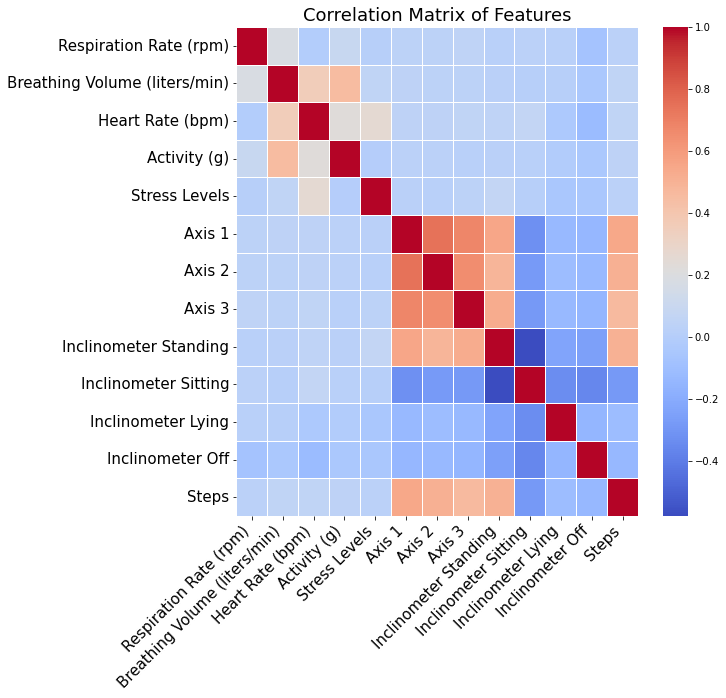

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the desired columns (features) from the combined_data DataFrame
selected_features = combined_data[['Respiration Rate (rpm)','Breathing Volume (liters/min)',
                                   'Heart Rate (bpm)','Activity (g)','Stress Levels',
                                  'Axis 1','Axis 2', 'Axis 3','Inclinometer Standing',
                                  'Inclinometer Sitting','Inclinometer Lying','Inclinometer Off','Steps']]

# Calculate the correlation matrix
correlation_matrix = selected_features.corr()

# Plot the correlation matrix using a heatmap with slanted x-axis labels
plt.figure(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, fmt=".2f", annot_kws={'size': 12})
plt.title('Correlation Matrix of Features', fontsize=18)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

plt.show()


## XGBoost Model (3 Stress Level Multi-Classification) (low f1-score)

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import shap
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the combined_data
# combined_data = pd.read_csv('combined_data.csv')  # Adjust filename as per your data

# Drop the feature "Time [s/256]"
# combined_data.drop(columns=['lux'], inplace=True)

# Specify the percentage of data to use
subset_percent = 1  # 80% of the data

# Sample a subset of the data
combined_data_subset = combined_data.sample(frac=subset_percent)

# Separate features and target variable
X = combined_data_subset.drop('Stress Levels', axis=1)
y = combined_data_subset['Stress Levels']

# Initialize XGBoost model
model = XGBClassifier()

# Initialize StratifiedKFold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Get the number of unique classes
num_classes = len(np.unique(y))

# Initialize lists to store feature importance values for each class
mean_feature_importance = np.zeros((num_classes, X.shape[1]))

# Initialize lists to store metrics for each class
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform 5-fold cross-validation
for fold_idx, (train_index, test_index) in enumerate(kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Use SHAP to calculate Shapley values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Reshape SHAP values to match the expected shape
    shap_values_reshaped = np.array(shap_values).reshape((num_classes, len(X_test), X.shape[1]))
    
    # Calculate mean Shapley values across all folds for each class
    for class_idx in range(num_classes):
        mean_feature_importance[class_idx] += np.abs(shap_values_reshaped[class_idx]).mean(axis=0)
    
    # Predict labels
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    # Append metrics to the lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print confusion matrix for each fold
    print(f"Confusion Matrix for Fold {fold_idx + 1}:\n{cm}")

# Calculate mean metrics across all folds
mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list, axis=0)
mean_recall = np.mean(recall_list, axis=0)
mean_f1 = np.mean(f1_list, axis=0)

# Print mean metrics for each class
print("\nMean Metrics across all Folds:")
print(f"Accuracy: {mean_accuracy}")
print(f"Precision: {mean_precision}")
print(f"Recall: {mean_recall}")
print(f"F1 Score: {mean_f1}")

# Print mean feature importance for each class
feature_names = X.columns
for class_idx in range(num_classes):
    print(f"Feature importance for Stress Level {class_idx}:")
    for name, importance in zip(feature_names, mean_feature_importance[class_idx]):
        print(f"{name}: {importance}")


Confusion Matrix for Fold 1:
[[35539  2781   636]
 [ 8496  8975   518]
 [ 2534  1214  2388]]
Confusion Matrix for Fold 2:
[[35422  2893   641]
 [ 8596  8886   507]
 [ 2514  1229  2393]]
Confusion Matrix for Fold 3:
[[35461  2869   626]
 [ 8459  9015   515]
 [ 2451  1277  2408]]
Confusion Matrix for Fold 4:
[[35350  2924   681]
 [ 8518  8935   537]
 [ 2549  1210  2377]]
Confusion Matrix for Fold 5:
[[35480  2817   658]
 [ 8680  8770   539]
 [ 2503  1206  2427]]

Mean Metrics across all Folds:
Accuracy: 0.7413539416468466
Precision: [0.76220605 0.6858576  0.67187845]
Recall: [0.91002063 0.49564182 0.39090613]
F1 Score: [0.82957933 0.57542544 0.49424136]
Feature importance for Stress Level 0:
Axis 1: 0.5902469456195831
Axis 2: 0.9590127319097519
Axis 3: 0.8859149813652039
Steps: 0.7999208569526672
Inclinometer Off: 1.2389171868562698
Inclinometer Standing: 0.785319909453392
Inclinometer Sitting: 0.670105591416359
Inclinometer Lying: 0.3340057320892811
Respiration Rate (rpm): 0.19640921428

## XGBoost Biclassification (Grouping Stress Levels 1 and 2 (mild and high stress) together)
## better f1-score, 
## will use this method
## uses 5 fold CV

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import shap
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the combined_data
# combined_data = pd.read_csv('combined_data.csv')  # Adjust filename as per your data

# Drop the feature "Time [s/256]"
# combined_data.drop(columns=['lux'], inplace=True)

# Specify the percentage of data to use
subset_percent = 1  # 80% of the data

# Sample a subset of the data
combined_data_subset = combined_data.sample(frac=subset_percent)

# Separate features and target variable
X = combined_data_subset.drop('Stress Levels', axis=1)
y = combined_data_subset['Stress Levels']

# Group stress levels 1 and 2 together
y_binary = y.apply(lambda x: 0 if x == 0 else 1)

# Initialize XGBoost model
model = XGBClassifier()

# Initialize StratifiedKFold cross-validation
kfold = StratifiedKFold(n_splits=2, shuffle=True)

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform 5-fold cross-validation
for fold_idx, (train_index, test_index) in enumerate(kfold.split(X, y_binary)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Use SHAP to calculate Shapley values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Predict labels
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append metrics to the lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print confusion matrix for each fold
    print(f"Confusion Matrix for Fold {fold_idx + 1}:\n{cm}")

# Calculate mean metrics across all folds
mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)

# Print mean metrics
print("\nMean Metrics across all Folds:")
print(f"Accuracy: {mean_accuracy}")
print(f"Precision: {mean_precision}")
print(f"Recall: {mean_recall}")
print(f"F1 Score: {mean_f1}")


Confusion Matrix for Fold 1:
[[83923 13466]
 [22616 37697]]
Confusion Matrix for Fold 2:
[[83479 13910]
 [22748 37565]]

Mean Metrics across all Folds:
Accuracy: 0.7693751506004997
Precision: 0.7332868598307212
Recall: 0.6239285062921758
F1 Score: 0.6742003318068432


## Shapley Feature Importance Graph, Statistically Signficant Features, Accuracy, F1-Score
## uses normal train test

Statistically significant features and their p-values:
Heart Rate (bpm): 0.0
Breathing Volume (liters/min): 3.296997143914192e-129
Adjusted Breathing Volume (liters/min): 7.551497104992693e-129
Inclinometer Lying: 9.270490690365275e-65
Inclinometer Standing: 1.6375188844360268e-14
Respiration Rate (rpm): 1.4518235056517553e-13
Inclinometer Sitting: 1.0427488300187078e-11
Axis 2: 2.2824324359649014e-05
Activity (g): 2.825908995703211e-05
Axis 1: 8.215426100537594e-05
Steps: 0.002706684246529552
Inclinometer Off: 0.010951418862603935

Metrics:
Accuracy: 0.774380282690532
Precision: 0.7378307742567788
Recall: 0.6319839567204552
F1 Score: 0.680817926045016


/Users//opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


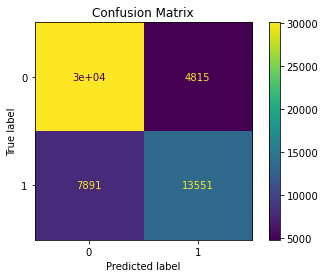


Feature importance:
Breathing Volume (liters/min): 0.6831821203231812
Adjusted Breathing Volume (liters/min): 0.6527661085128784
Heart Rate (bpm): 0.5090823173522949
Respiration Rate (rpm): 0.22361497581005096
Inclinometer Off: 0.17919570207595825
Inclinometer Lying: 0.074996218085289
Axis 1: 0.05954846739768982
Inclinometer Standing: 0.05897299572825432
Inclinometer Sitting: 0.05012506619095802
Activity (g): 0.04313051700592041
Axis 2: 0.036933835595846176
Axis 3: 0.032710228115320206
Steps: 0.0008386597037315369


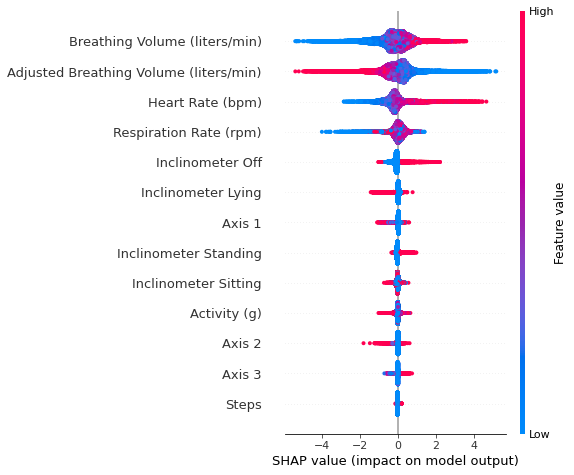

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# Load the combined_data
# combined_data = pd.read_csv('combined_data.csv')  # Adjust filename as per your data

# Drop the feature "Time [s/256]"
# combined_data.drop(columns=['lux'], inplace=True)

# Specify the percentage of data to use
subset_percent = 1  # 100% of the data

# Sample a subset of the data
combined_data_subset = combined_data.sample(frac=subset_percent)

# Remove outliers using z-score
z_scores = zscore(combined_data_subset)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
combined_data_subset = combined_data_subset[filtered_entries]

# Separate features and target variable
X = combined_data_subset.drop('Stress Levels', axis=1)
y = combined_data_subset['Stress Levels']

# Group stress levels 1 and 2 together
y_binary = y.apply(lambda x: 0 if x == 0 else 1)

# Split data into train and test sets (stratified split)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, stratify=y_binary)

# Perform t-test for each feature
p_values = {}
for feature in X.columns:
    stress_level_0 = X_train[y_train == 0][feature]
    stress_level_1 = X_train[y_train == 1][feature]
    _, p_value = ttest_ind(stress_level_0, stress_level_1)
    if p_value < 0.05:  # Adjust alpha value if needed
        p_values[feature] = p_value

# Sort p-values and print significant features
sorted_p_values = sorted(p_values.items(), key=lambda x: x[1])
print("Statistically significant features and their p-values:")
for feature, p_value in sorted_p_values:
    print(f"{feature}: {p_value}")

# Initialize XGBoost model
model = XGBClassifier()

# Fit the model
model.fit(X_train, y_train)

# Predict labels
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plotting confusion matrix
plot_confusion_matrix(model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# Use SHAP to calculate Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Get the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Zip feature names with their corresponding mean SHAP values
feature_importance = list(zip(X.columns, mean_shap_values))

# Sort feature importance by the absolute SHAP values in descending order
feature_importance.sort(key=lambda x: -x[1])

# Print feature importance
print("\nFeature importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

# Plotting feature importance using SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.show()
